# Cross-Model Activation Patching

This notebook demonstrates cross-model activation patching, where activations are collected from a **source model** and patched into a **target model**. This enables experiments like:
- Patching between different checkpoints of the same model
- Patching between models with the same architecture but different training
- Patching between different models (if hidden dimensions match)

## Validation Test

To verify the cross-model patching implementation works correctly, we'll run a validation:
**patching a model with its own activations should produce identical results to regular patching.**

If `source_pipeline == pipeline`, then:
- Regular patching: collect activations from `pipeline`, patch into `pipeline`
- Cross-model patching: collect activations from `source_pipeline`, patch into `pipeline`

These should be equivalent when both pipelines point to the same model.

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import torch
from causalab.neural.pipeline import LMPipeline
from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.causal.causal_utils import save_counterfactual_examples
from causalab.tasks.MCQA.counterfactuals import different_symbol
from causalab.tasks.MCQA.token_positions import create_token_positions
from causalab.experiments.filter import filter_dataset

# Setup
causal_model = positional_causal_model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"

# Create the pipeline (this will be both source and target)
pipeline = LMPipeline(
    model_name,
    max_new_tokens=1,
    device=device,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    max_length=32,
)

def metric(neural_output: dict[str, str], causal_output: str) -> bool:
    return (
        causal_output in neural_output["string"]
        or neural_output["string"] in causal_output
    )


print(f"Model loaded on {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model loaded on cuda


## Create Test Dataset

We'll use a filtered dataset for testing, similar to notebook 03.

In [2]:
# Generate dataset
size = 64
dataset = [different_symbol() for _ in range(size)]

# Filter to examples the model gets correct
filtered_dataset = filter_dataset(
    dataset=dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=metric,
    batch_size=32,
)

print(f"Filtered dataset size: {len(filtered_dataset)}")
print(f"\nExample:")
print(f"  Input: {filtered_dataset[0]['input']['raw_input']}")
print(
    f"  Counterfactual: {filtered_dataset[0]['counterfactual_inputs'][0]['raw_input']}"
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Filtered dataset size: 58

Example:
  Input: The shirt is yellow. What color is the shirt?
X. green
H. yellow
Answer:
  Counterfactual: The shirt is yellow. What color is the shirt?
G. green
N. yellow
Answer:


## Save Dataset for Heatmap Functions

The `run_interchange_score_heatmap` function expects a path to a saved dataset.

In [3]:
# Save dataset to disk
temp_dir = "./temp_cross_model_test"
os.makedirs(temp_dir, exist_ok=True)
dataset_path = os.path.join(temp_dir, "filtered_dataset")
save_counterfactual_examples(filtered_dataset, dataset_path)
print(f"Dataset saved to {dataset_path}")

Dataset saved to ./temp_cross_model_test/filtered_dataset


## Build Interchange Targets

We'll patch residual stream positions across all layers, similar to notebook 03.

In [4]:
from causalab.experiments.interchange_targets import build_residual_stream_targets

# Get token positions
all_token_positions = create_token_positions(pipeline)
ordered_position_names = [
    "correct_symbol",
    "correct_symbol_period",
    "symbol0",
    "symbol0_period",
    "symbol1",
    "symbol1_period",
    "last_token",
]
token_positions = [all_token_positions[name] for name in ordered_position_names]

# All layers
num_layers = pipeline.model.config.num_hidden_layers
layers = [-1] + list(range(num_layers))

# Build targets
targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers,
    token_positions=token_positions,
    mode="one_target_per_unit",
)

print(f"Built {len(targets)} interchange targets")
print(f"Layers: {len(layers)} (embedding + {num_layers} transformer layers)")
print(f"Token positions: {len(token_positions)}")

Built 119 interchange targets
Layers: 17 (embedding + 16 transformer layers)
Token positions: 7


## Run Regular Patching with Heatmaps

First, run standard interchange interventions **without** cross-model patching and generate heatmaps.

Running interventions: 100%|██████████| 119/119 [00:20<00:00,  5.93it/s]


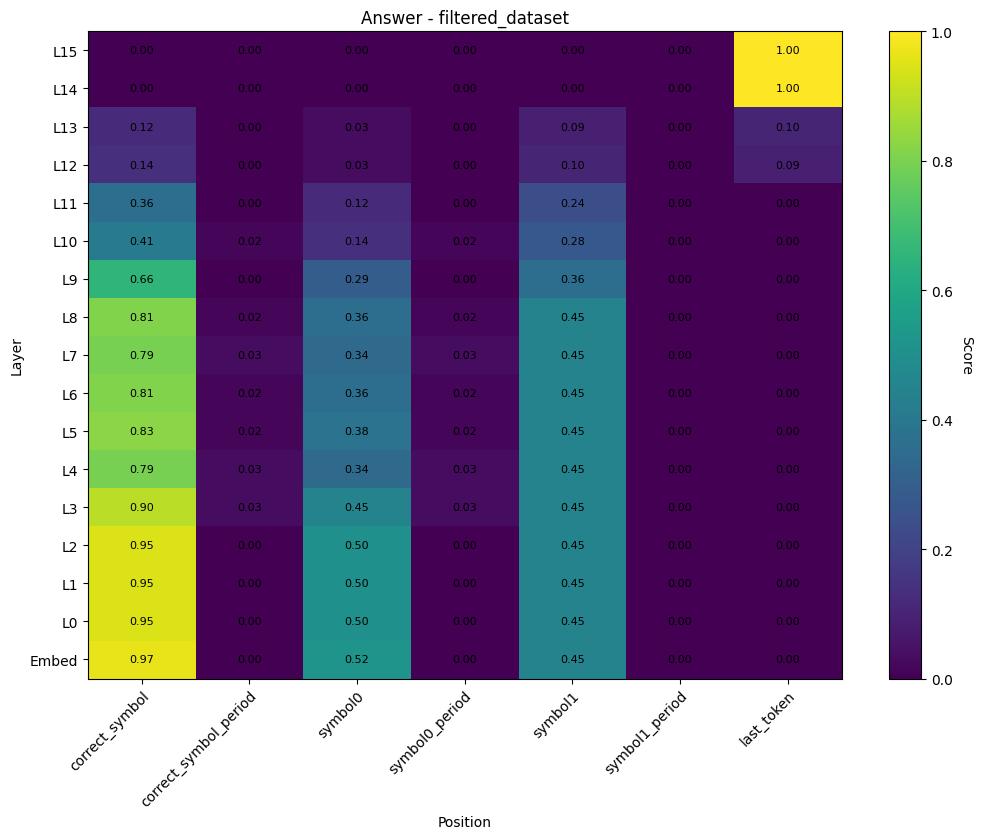

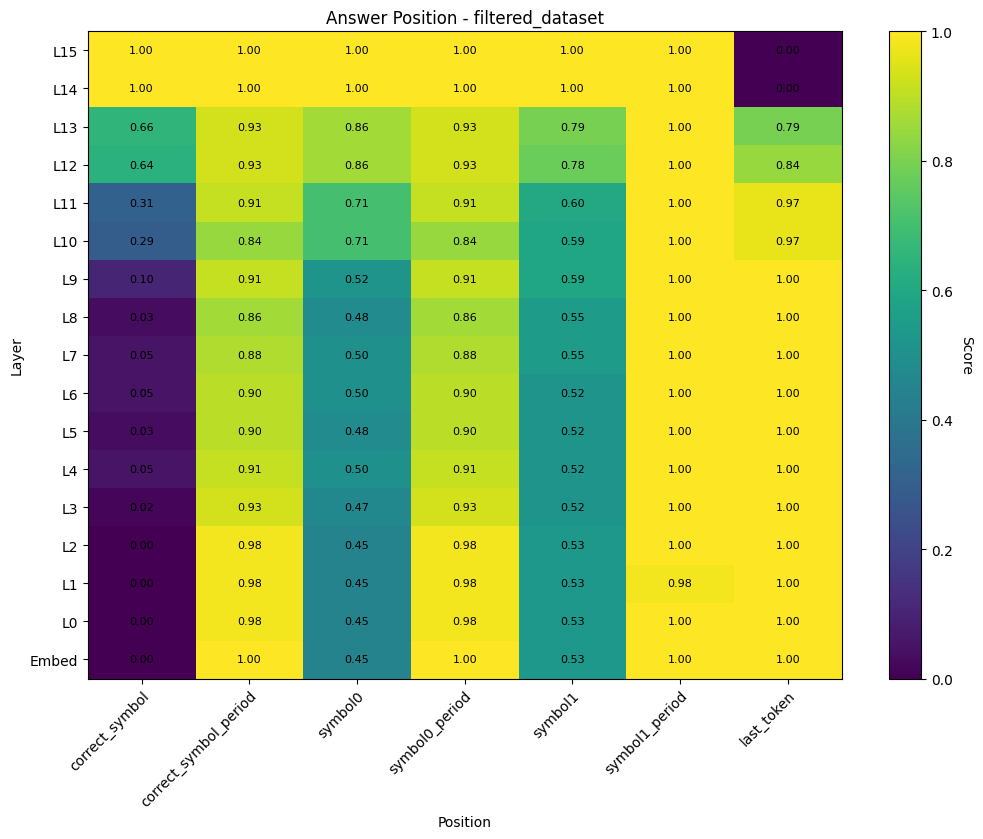


Regular patching complete!
Average score: 0.4704


In [5]:
from causalab.experiments.jobs.interchange_score_grid import (
    run_interchange_score_heatmap,
)

regular_output_dir = os.path.join(temp_dir, "regular_patching")

regular_result = run_interchange_score_heatmap(
    causal_model=causal_model,
    interchange_targets=targets,
    dataset_path=dataset_path,
    pipeline=pipeline,
    batch_size=32,
    target_variable_groups=[("answer",), ("answer_position",)],
    output_dir=regular_output_dir,
    metric=metric,
    verbose=True,
    source_pipeline=None,  # Regular patching
)

print("\nRegular patching complete!")
print(f"Average score: {regular_result['metadata']['avg_score']:.4f}")

## Run Cross-Model Patching with Heatmaps

Now run cross-model patching where `source_pipeline == pipeline`. This should produce **identical** heatmaps.

Running interventions: 100%|██████████| 119/119 [00:30<00:00,  3.90it/s]


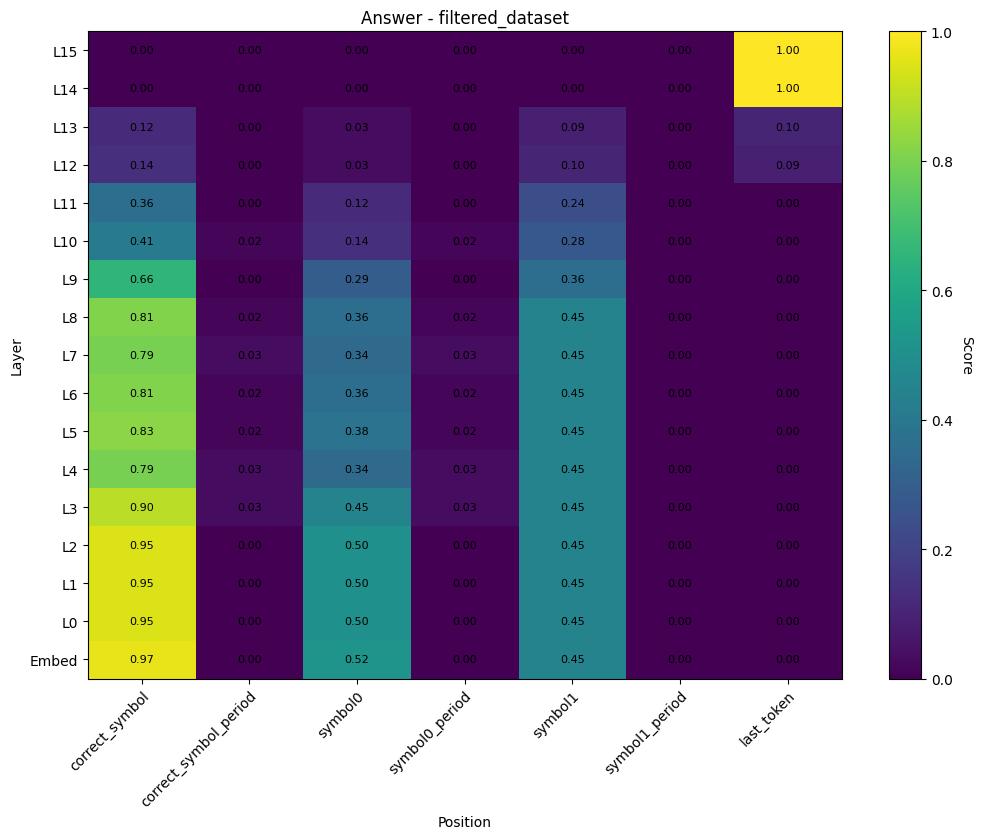

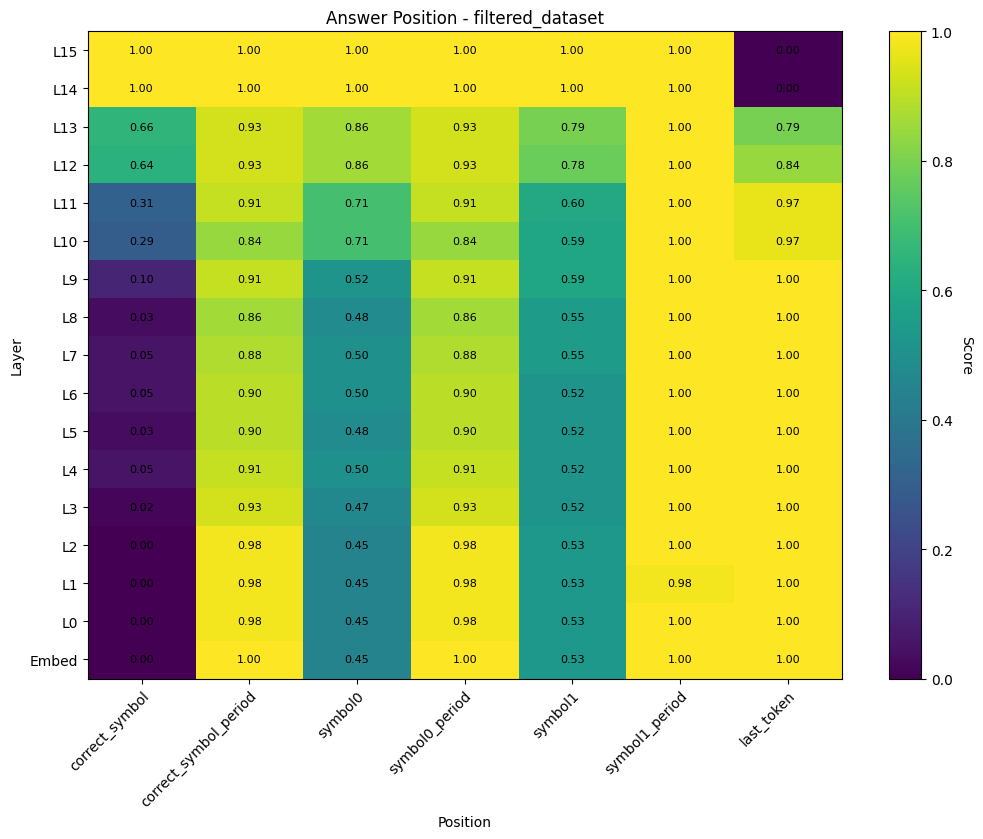


Cross-model patching complete!
Average score: 0.4704


In [6]:
cross_model_output_dir = os.path.join(temp_dir, "cross_model_patching")

cross_model_result = run_interchange_score_heatmap(
    causal_model=causal_model,
    interchange_targets=targets,
    dataset_path=dataset_path,
    pipeline=pipeline,
    batch_size=32,
    target_variable_groups=[("answer",), ("answer_position",)],
    output_dir=cross_model_output_dir,
    metric=metric,
    verbose=True,
    source_pipeline=pipeline,  # Cross-model patching with same model
)

print("\nCross-model patching complete!")
print(f"Average score: {cross_model_result['metadata']['avg_score']:.4f}")

## Compare Scores

The scores should be identical between regular and cross-model patching.

In [7]:
import numpy as np

# Compare scores for each variable group
all_match = True
for var_group in [("answer",), ("answer_position",)]:
    regular_scores = regular_result["scores"][var_group]
    cross_model_scores = cross_model_result["scores"][var_group]

    # Check if all scores match
    mismatches = []
    for key in regular_scores:
        if key not in cross_model_scores:
            mismatches.append((key, "missing", None))
        elif abs(regular_scores[key] - cross_model_scores[key]) > 1e-6:
            mismatches.append((key, regular_scores[key], cross_model_scores[key]))

    if mismatches:
        all_match = False
        print(f"\nMISMATCH for {var_group}:")
        for key, reg, cross in mismatches[:5]:  # Show first 5
            print(f"  {key}: regular={reg} vs cross-model={cross}")
    else:
        # Compute summary stats
        scores_list = list(regular_scores.values())
        print(f"\n{var_group}:")
        print(f"  All {len(regular_scores)} scores match!")
        print(f"  Mean score: {np.mean(scores_list):.4f}")
        print(f"  Min score: {np.min(scores_list):.4f}")
        print(f"  Max score: {np.max(scores_list):.4f}")

if all_match:
    print("\n" + "=" * 60)
    print("SUCCESS: Cross-model patching produces identical scores!")
    print("=" * 60)
else:
    print("\n" + "=" * 60)
    print("FAILURE: Scores do not match!")
    print("=" * 60)


('answer',):
  All 119 scores match!
  Mean score: 0.1966
  Min score: 0.0000
  Max score: 1.0000

('answer_position',):
  All 119 scores match!
  Mean score: 0.7441
  Min score: 0.0000
  Max score: 1.0000

SUCCESS: Cross-model patching produces identical scores!


## Display Heatmaps Side-by-Side

Visual comparison of the heatmaps from regular and cross-model patching.

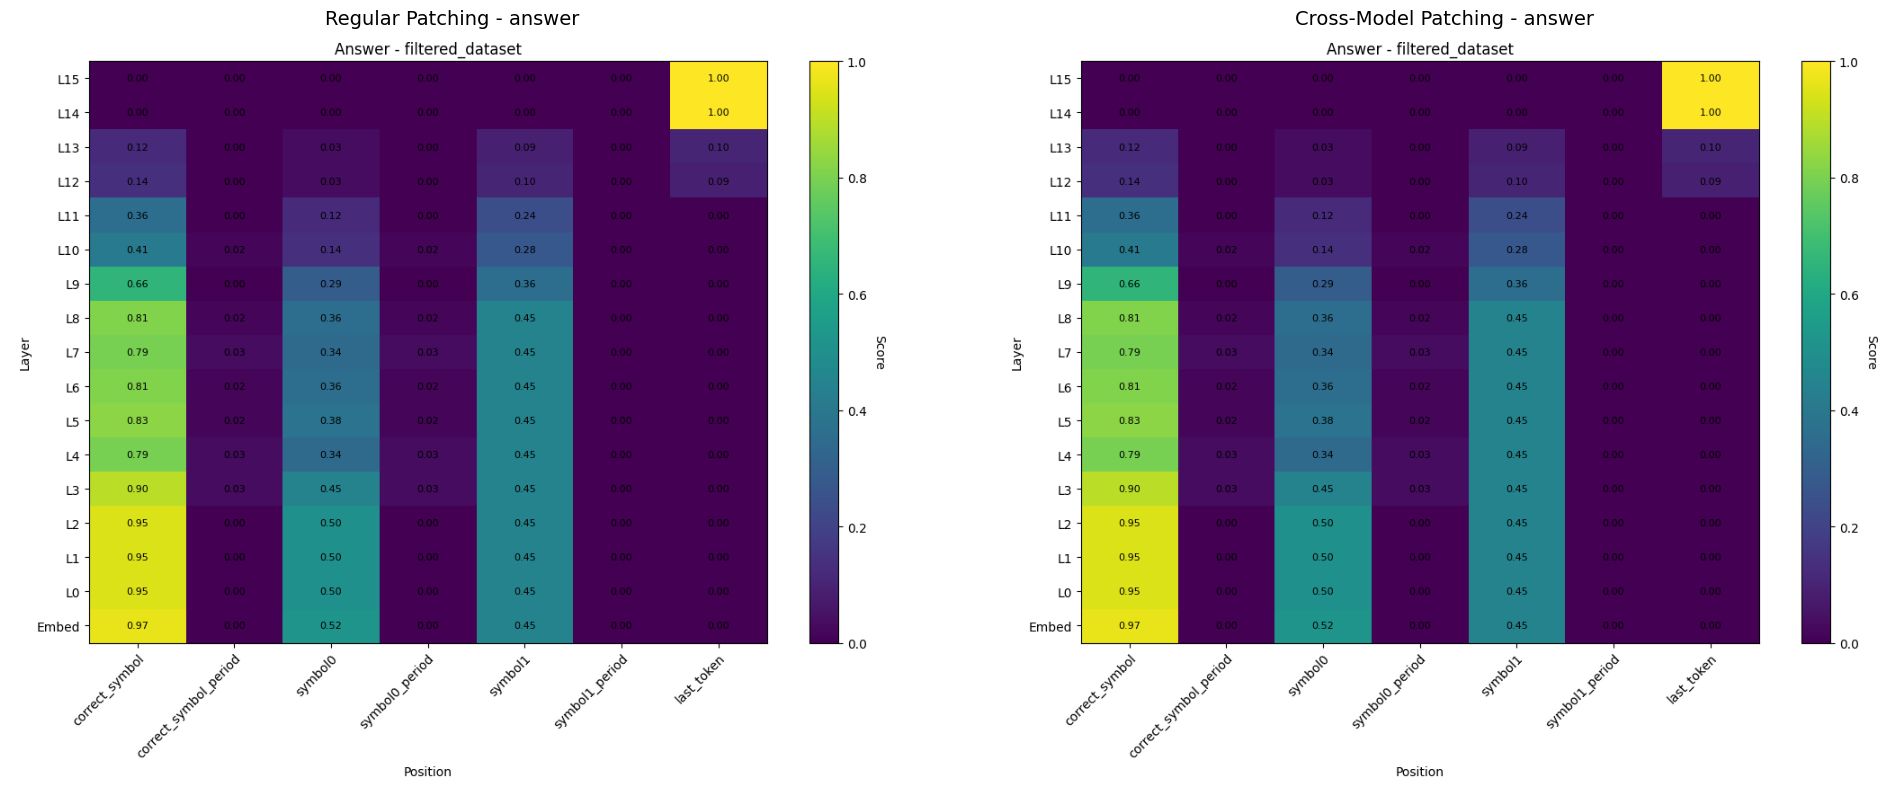

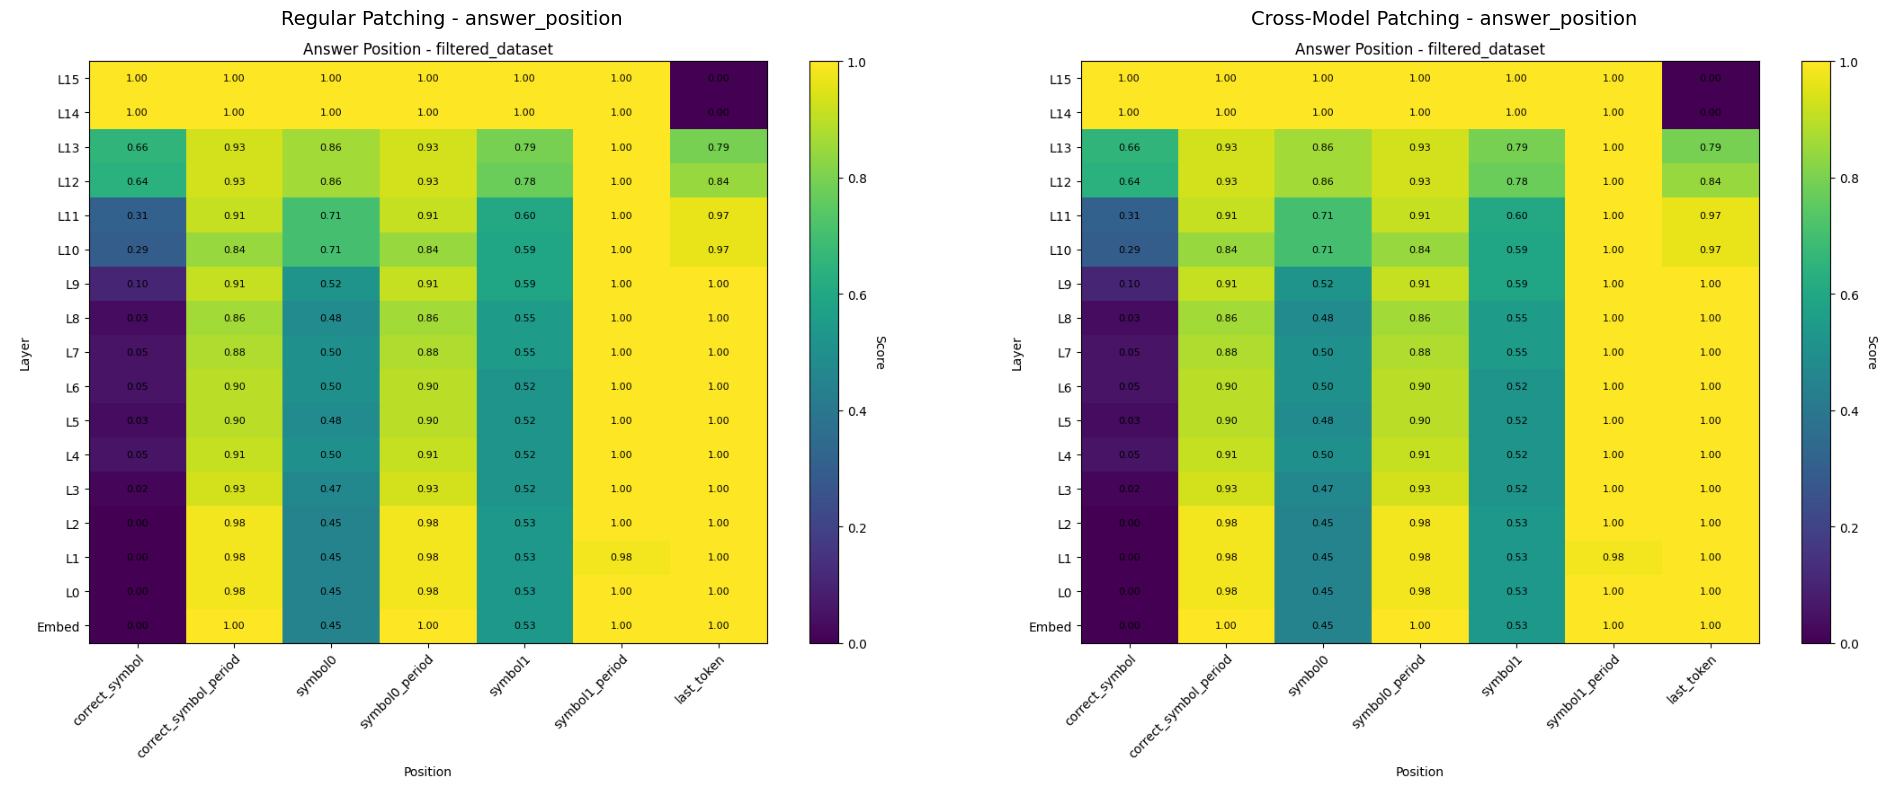

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Display heatmaps for each variable
for var_name in ["answer", "answer_position"]:
    regular_heatmap_path = os.path.join(regular_output_dir, "heatmaps", f"filtered_dataset_{var_name}.png")
    cross_model_heatmap_path = os.path.join(cross_model_output_dir, "heatmaps", f"filtered_dataset_{var_name}.png")
    
    if os.path.exists(regular_heatmap_path) and os.path.exists(cross_model_heatmap_path):
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Regular patching heatmap
        regular_img = Image.open(regular_heatmap_path)
        axes[0].imshow(regular_img)
        axes[0].set_title(f"Regular Patching - {var_name}", fontsize=14)
        axes[0].axis("off")

        # Cross-model patching heatmap
        cross_model_img = Image.open(cross_model_heatmap_path)
        axes[1].imshow(cross_model_img)
        axes[1].set_title(f"Cross-Model Patching - {var_name}", fontsize=14)
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Heatmap files not found for {var_name}")
        print(f"  Regular: {regular_heatmap_path}")
        print(f"  Cross-model: {cross_model_heatmap_path}")

## Cleanup

Remove temporary files created during testing.

In [12]:
# Uncomment to clean up temporary files
# import shutil
# shutil.rmtree(temp_dir)
# print(f"Cleaned up {temp_dir}")

print(f"Temporary files are in: {temp_dir}")
print("Uncomment the cleanup code above to remove them.")

Temporary files are in: ./temp_cross_model_test
Uncomment the cleanup code above to remove them.


## Conclusion

This notebook verified that the cross-model patching implementation is correct by showing that:

1. **Regular patching** (activations collected and patched within the same model)
2. **Cross-model patching with same model** (activations explicitly collected from source, then patched)

produce **identical scores and heatmaps** when the source and target are the same model.

### Key Observations

- The heatmaps for `answer` variable show signal at the `correct_symbol` position in early layers
- The heatmaps for `answer_position` variable show signal at `last_token` around layer 15
- Both regular and cross-model patching produce the same results, validating the implementation

### Next Steps

With this validated, you can now use cross-model patching for:
- **Checkpoint analysis**: Compare how representations evolve during training
- **Model comparison**: Patch between models with matching architectures
- **Transfer experiments**: Test if representations from one model can drive behavior in another